In [63]:
import pickle
from rassp import netutil
import os

use_gpu=False
#model_dir='checkpoints'
model_dir='zia5'


MODELS = {
    'FormulaNet': {
        'checkpoint': os.path.join(model_dir, 'test.78955030.00000000.model'),
        'meta': os.path.join(model_dir, 'test.78955030.meta'),

        # NOTE(2023-01-24): FN currently has a reduced set of valid mol constraints bc this is what we trained with
        # and there is currently an outstanding bug where changing N_ATOMS here breaks FN predictions in subtle ways.
        'override_constraints': {
            'n_atom': 48,
            # 'n_formula': 4096,
            'n_formula': 100000,
            # 'n_subset': 12288,
            'n_subset': 49152,
        },
    },
}

model_name='FormulaNet'
meta_path = MODELS[model_name]['meta']
ckpt_path = MODELS[model_name]['checkpoint']
override_constraints = MODELS[model_name]['override_constraints']
meta = pickle.load(open(meta_path, 'rb'))

feat_config = meta['featurize_config']
for key, val in override_constraints.items():
    if key == 'n_atom':
        feat_config['MAX_N'] = val
    if key == 'n_formula':
        feat_config['explicit_formulae_config']['max_formulae'] = val
    if key == 'n_subset':
        feat_config['vert_subset_samples_n'] = val

if use_gpu and not torch.cuda.is_available():
    use_gpu = False

predictor = netutil.PredModel(
    meta_path,
    ckpt_path,
    USE_CUDA=use_gpu,
    data_parallel=False,
    featurize_config_update=feat_config,
)


2023-03-16 08:44:08,389 - rassp.netutil - WARNING - NOT USING GPU!


In [49]:
import pandas as pd
trd = pd.read_parquet('test.pq')

In [50]:
from rdkit import Chem

molidx = [ 14,42,815,1414 ]

smiles = list(trd.iloc[molidx].smiles)
valid_mols = [ Chem.AddHs(Chem.MolFromSmiles(s)) for s in smiles ]

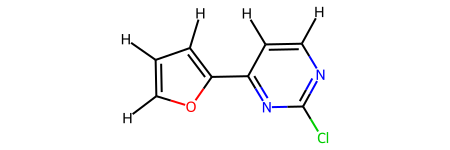

In [51]:
valid_mols[1]

In [64]:
predictions = predictor.pred(
    valid_mols,
    progress_bar=True,
    normalize_pred=True,
    output_hist_bins=True,
    batch_size=2, # XXX
    dataloader_config={
        'pin_memory': False,
        'num_workers': 0, # XXX
        'persistent_workers': False,
    },
    benchmark_dataloader=False,
)

100%|██████████| 4/4 [00:37<00:00,  9.45s/it]


In [59]:
idx=3

shit_nist=trd[trd.smiles == smiles[idx]]
shit_nist

,rdmol,spect,smiles
7279,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[18.0, 1.0], [28.0, 11.99], [29.0, 29.97], [3...",C1=C(C(=C(C(=C1F)F)F)F)COC=O


In [60]:
idx2=0

In [65]:
import matchms
import numpy as np

mzi=np.array(list(shit_nist.iloc[idx2].spect))
shit1 = matchms.Spectrum(mz=mzi[:,0],intensities=mzi[:,1])
mzi=predictions['pred_binned'][idx].astype(float)
shit2 = matchms.Spectrum(mz=mzi[:,0],intensities=mzi[:,1])

2023-03-16 08:45:21,837:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2023-03-16 08:45:21,837 - matchms - WARNING - No precursor_mz found in metadata.


2023-03-16 08:45:21,839:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2023-03-16 08:45:21,839 - matchms - WARNING - No precursor_mz found in metadata.


<Axes: title={'center': 'Spectrum comparison'}, xlabel='m/z', ylabel='Intensity'>

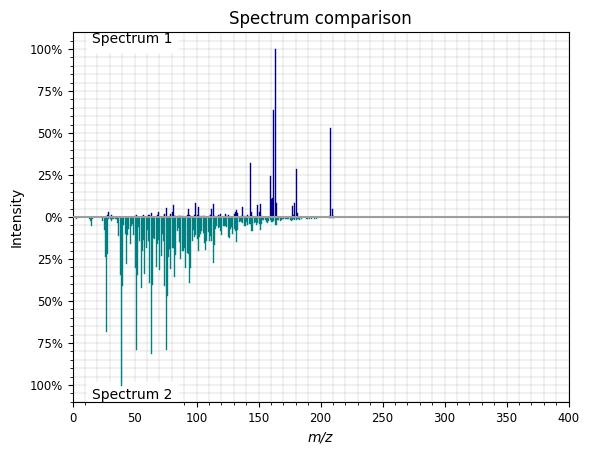

In [47]:
from matchms.plotting import plot_spectra_mirror
plot_spectra_mirror(shit1,shit2)

<Axes: title={'center': 'Spectrum comparison'}, xlabel='m/z', ylabel='Intensity'>

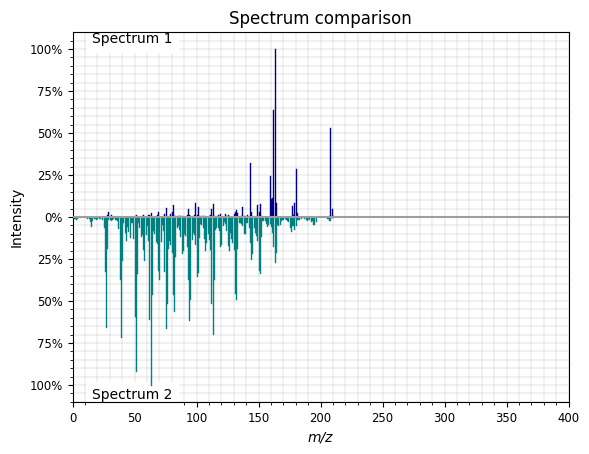

In [56]:
from matchms.plotting import plot_spectra_mirror
plot_spectra_mirror(shit1,shit2)

<Axes: title={'center': 'Spectrum comparison'}, xlabel='m/z', ylabel='Intensity'>

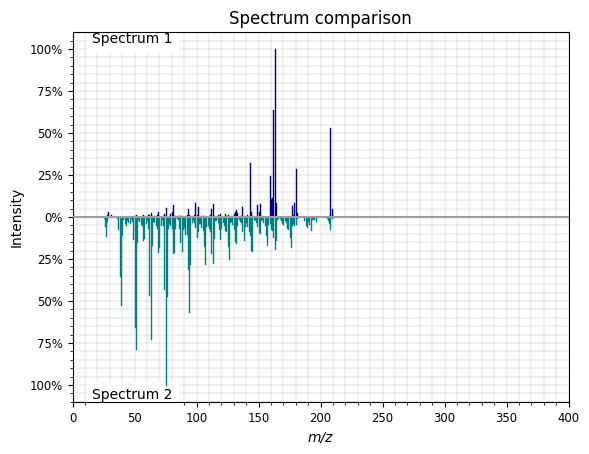

In [62]:
from matchms.plotting import plot_spectra_mirror
plot_spectra_mirror(shit1,shit2)

<Axes: title={'center': 'Spectrum comparison'}, xlabel='m/z', ylabel='Intensity'>

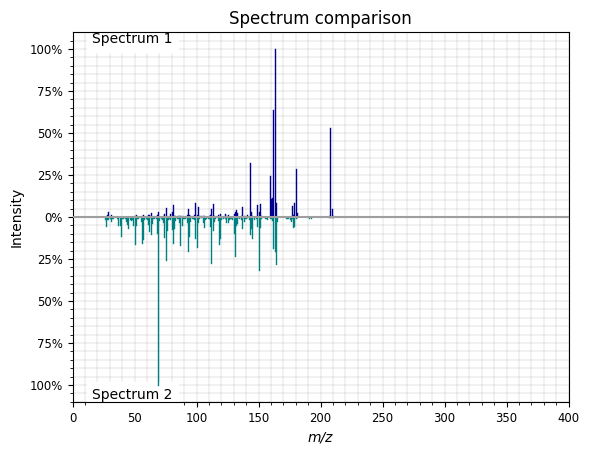

In [66]:
from matchms.plotting import plot_spectra_mirror
plot_spectra_mirror(shit1,shit2)

2023-03-16 08:50:00,293:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2023-03-16 08:50:00,293 - matchms - WARNING - No precursor_mz found in metadata.


2023-03-16 08:50:00,294:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2023-03-16 08:50:00,294 - matchms - WARNING - No precursor_mz found in metadata.


<Axes: title={'center': 'Spectrum comparison'}, xlabel='m/z', ylabel='Intensity'>

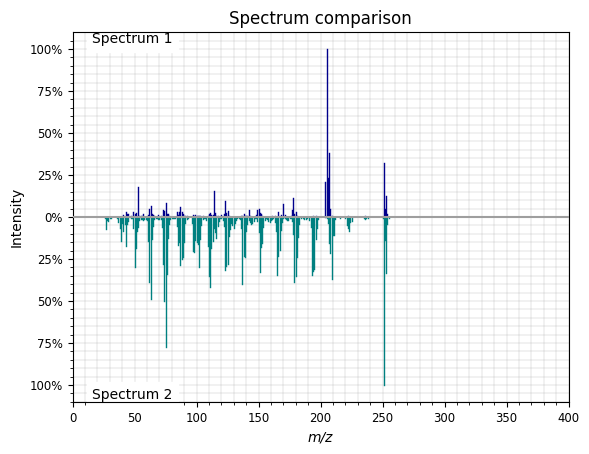

In [73]:
idx=2
idx2=0
shit_nist=trd[trd.smiles == smiles[idx]]
mzi=np.array(list(shit_nist.iloc[idx2].spect))
shit1 = matchms.Spectrum(mz=mzi[:,0],intensities=mzi[:,1])
mzi=predictions['pred_binned'][idx].astype(float)
shit2 = matchms.Spectrum(mz=mzi[:,0],intensities=mzi[:,1])
plot_spectra_mirror(shit1,shit2)